In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


import json
from pandas.io.json import json_normalize
# Any results you write to the current directory are saved as output.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def loadData(filename='train.csv', nrows=None):
    """Load data file into data frame

    Args:
        filename: path of the data file to read
        nrows: Number of rows of file to read, None = read all

    Returns:
        data frame of the data file
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(filename, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(filename)}. Shape: {df.shape}")
    return df

In [4]:
%%time
dfTrain = loadData("train.csv")

Loaded train.csv. Shape: (903653, 55)
Wall time: 2min 21s


In [6]:
%%time
dfTest = loadData("test.csv")

Loaded test.csv. Shape: (804684, 53)
Wall time: 2min 6s


In [4]:
constCols = [c for c in dfTrain.columns if dfTrain[c].nunique(dropna=False)==1 ]
constCols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [5]:
dfTrain = dfTrain.drop(constCols, axis = 1)
len(constCols)

19

In [6]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 36 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                       

#### Convert data type

In [10]:
def convertDtype(df, colNames, dtype):
    for col in colNames:
        df[col] = df[col].astype(dtype)
    return df

def dfFillNa(df, colNames):
    for col in colNames:
        df[col] = df[col].fillna(0)
    return df

In [8]:
def checkCol(df, colName, isCata = True):
    numRow = df.shape[0]
    print(colName, ':')
    print('Any NA?: ', df[colName].isnull().values.any())
    if df[colName].isnull().values.any():
        numNA = sum(df[colName].isnull().values)
        print ('    # of NA: ', numNA)
        print ('    NA%:     ', numNA/numRow)
    if isCata:
        levelList = df[colName].unique()
        print('Different levels: ', len(levelList), levelList)
        speList = ['(not set)', '(not provided)', '(none)', '(Other)']
        for spe in speList:
            if spe in levelList:
                print(spe, 'percentage: ', sum(df[colName] == spe)/numRow)
        matplotlib.rcParams['figure.figsize'] = (12, 6)
        sns.catplot(y=colName, kind="count", data=dfTrain)
        
    else:
        print('range: ', min(df[colName].astype(float).dropna()), max(df[colName].astype(float).dropna()))

In [1]:
checkCol(dfTrain, 'geoNetwork.metro', True)

NameError: name 'checkCol' is not defined

| Col | to dtype |
|---|---|
| sessionId | drop |
| visitId | drop |
| totals.bounces | fillna(0), bool |
| totals.hits | int |
| totals.newVisits | fillna(0), bool |
| totals.pageviews | fillna(0), int |
| totals.transactionRevenue | fillna(0), int |
| trafficSource.campaignCode | drop |



In [11]:
def clearRawDF(df):
    df = df.drop(['sessionId', 'visitId', 'trafficSource.campaignCode'], axis = 1)
    df = dfFillNa(df, ['totals.bounces', 'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue'])
    df = convertDtype(df, ['totals.bounces', 'totals.newVisits'], bool)
    df = convertDtype(df, ['totals.hits', 'totals.pageviews', 'totals.transactionRevenue'], int)
    return df

In [12]:
dfTrain = clearRawDF(dfTrain)

In [13]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 33 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                              903653 non-null object
geoNetwork.metro                          

#### Add binary variable hasRevenue

In [14]:
dfTrain['hasRevenue'] = dfTrain['totals.transactionRevenue']>5000

hasRevenue :
Any NA?:  False
Different levels:  2 [False  True]


/Users/Tianyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


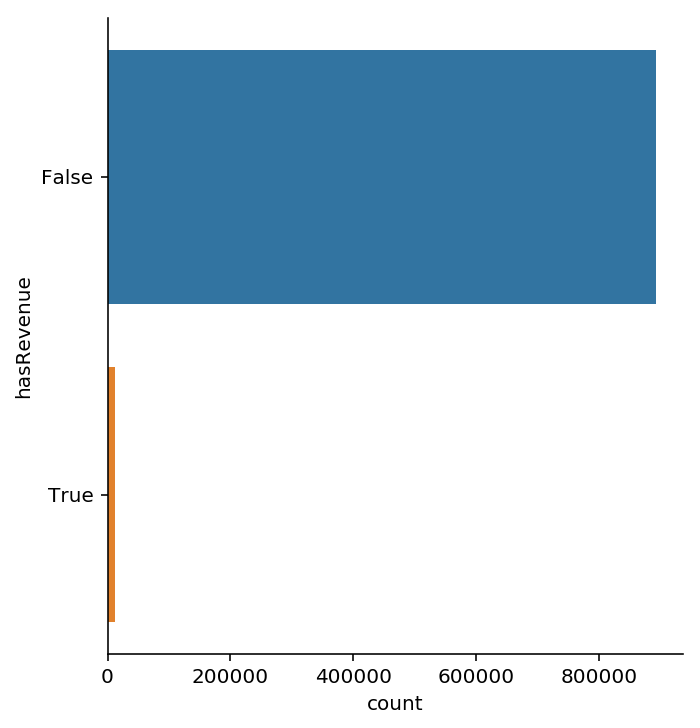

In [15]:
checkCol(dfTrain, 'hasRevenue', True)

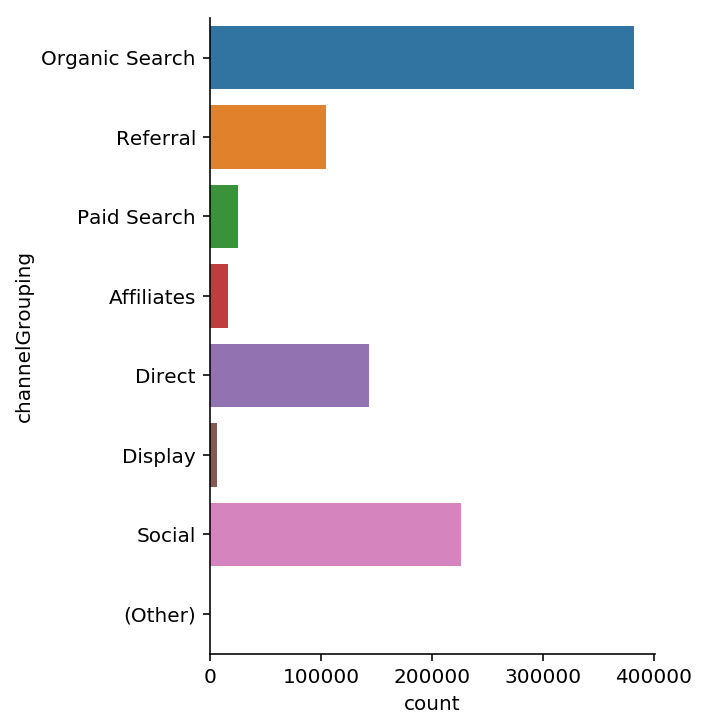

In [29]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.catplot(y="channelGrouping", kind="count", data=dfTrain)


####  $\uparrow$ Might want to put four least groups into one

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfTrain, test_size=0.2, random_state = 1)
train.shape

(722922, 34)

In [19]:
test.shape

(180731, 34)

In [20]:
train.to_csv('dataset/dfTrain.csv')
test.to_csv('dataset/dfTest.csv')